

### **Environment Setup:**

In [1]:
%pip install -qq langchain langchain-nvidia-ai-endpoints gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 549.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.9/393.9 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93

In [2]:
import os
os.environ["NVIDIA_API_KEY"] = "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"

In [3]:

from langchain_nvidia_ai_endpoints import ChatNVIDIA
for model in ChatNVIDIA.get_available_models():
  if "mistral" in model.id or "meta" in model.id:
    print(model.id)

meta/llama-3.1-8b-instruct
mistralai/mamba-codestral-7b-v0.1
meta/llama2-70b
meta/llama3-70b-instruct
mistralai/mistral-7b-instruct-v0.2
meta/llama-3.1-70b-instruct
meta/llama3-8b-instruct
mistralai/mixtral-8x7b-instruct-v0.1
meta/codellama-70b
liuhaotian/llava-v1.6-mistral-7b
mistralai/mixtral-8x22b-instruct-v0.1
meta/llama-3.1-405b-instruct
mistralai/mistral-large
mistralai/codestral-22b-instruct-v0.1
nv-mistralai/mistral-nemo-12b-instruct
mistralai/mistral-7b-instruct-v0.3


In [4]:
from functools import partial
from rich.console import Console
from rich.style import Style
from rich.theme import Theme

console = Console()
base_style = Style(color="#76B900", bold=True)
pprint = partial(console.print, style=base_style)

In [5]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
for model in NVIDIAEmbeddings.get_available_models():
    print(model.id)

NV-Embed-QA
nvidia/nv-embedqa-mistral-7b-v2
baai/bge-m3
snowflake/arctic-embed-l
nvidia/nv-embed-v1
nvidia/nv-embedqa-e5-v5


In [6]:
# NVIDIAEmbeddings.get_available_models()
embedder = NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5")

# ChatNVIDIA.get_available_models()
instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x22b-instruct-v0.1")


<br>

## 1: Generate Synthetic Data.

To start making a semantic guardrail, we obviously need to start out with some goals.

- **Assumption:** Let's say we'd like to make a Basura Chatbot that should primarily respond to company-relevant details!

- **Plan of Action**: To help identify what kinds of entries we're dealing with, it's a good idea to generate some representative inputs to define what are *good* and *poor* inputs to respond to. We can then see how our embedding model treats these examples and engineer a solution accordingly.

Unfortunately, we don't have any real data with us, so it looks like synthetic generation will have to do!


In [7]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import ChatMessage
from operator import itemgetter

## Useful method for mistral, which is currently tuned to output numbered outputs
def EnumParser(*idxs):
    '''Method that pulls out values from a mistral model that outputs numbered entries'''
    idxs = idxs or [slice(0, None, 1)]
    entry_parser = lambda v: v if ('. ' not in v) else v[v.index('. ')+2:]
    out_lambda = lambda x: [entry_parser(v).strip() for v in x.split("\n")]
    return StrOutputParser() | RunnableLambda(lambda x: itemgetter(*idxs)(out_lambda(x)))

instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1") | EnumParser()

from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

gen_prompt = {'input' : lambda x:x} | ChatPromptTemplate.from_template(
    "Please generate 20 representative conversations that would be {input}."
    "Note that Basura is a waste management company in New York, which provide its clients with insights about the garbage generated at clients' properties"
    "Basura just collects the data and doesn't involve with garbage handling in anyway"
    " Make sure all of the questions are very different in phrasing and content."
    " Do not respond to the questions; just list them. Make sure all of your outputs are numbered."
    " Example Response: 1. <question>\n2. <question>\n3. <question>\n..."
)

## Some that directly reference Basura
responses_1 = (gen_prompt | instruct_llm).invoke(
    " reasonable for a Basura chatbot to be able to answer."
    " Vary the context to  Basura business, general waste management questions, governament policies etc."
)
print("Reasonable Basura Responses:", *responses_1, "", sep="\n")

## And some that do not
responses_2 = (gen_prompt | instruct_llm).invoke(
    " be reasonable for a waste management chatbot to be able to answer. Make sure to vary"
    " the context to geenral waste management questions, governament policies etc."
)
print("Reasonable General Responses:", *responses_2, "", sep="\n")

## Irrelevant responses
responses_3 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for an Basura chatbot to answer,"
    " as it is irrelevant and will not be useful to answer (though not inherently harmful)."
)
print("Irrelevant Responses:", *responses_3, "", sep="\n")

responses_4 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for a chatbot (Basura's or Generally) to answer,"
    " as an automated response will either be overly insensitive or offensive."
)
print("Harmful non-Basura", *responses_4, "", sep="\n")

## Feel free to try your own generations instead

good_responses = responses_1 + responses_2
poor_responses = responses_3 + responses_4

Reasonable Basura Responses:
"Hi Basura, can you provide me with a breakdown of the types of waste generated at my property last month?"
"Hello Basura, I'm interested in learning more about waste management best practices for my business. Can you offer any advice?"
"Hey Basura, I'm curious - what are the most common types of waste you see in the properties you monitor?"
"Hi there, I would like to reduce the amount of waste my business produces. Can Basura provide me with any insights on how to do this?"
"Hello Basura, I'm a government official and I'm looking for ways to improve waste management policies in our city. Can you help?"
"Hi Basura, I'm concerned about the environmental impact of my business's waste. Can you provide me with any data on our waste streams?"
"Hello Basura, I would like to set up a recycling program at my property. Do you have any resources or recommendations?"
"Hey Basura, I'm confused about the different waste management regulations in New York. Can you clarif

<br>

#### **Timing Solutions**

The `%%time` utility does not work for asynchronous solutions in the notebook, so the following is a scope-based timing utility which should make our lives easier. Below, we define it and test out how long it takes to embed the first 10 documents:

In [8]:
import time
import numpy as np

class Timer():
    '''Useful timing utilities (%%time is great, but doesn't work for async)'''
    def __enter__(self):
      self.start = time.perf_counter()

    def __exit__(self, *args, **kwargs):
        elapsed = time.perf_counter() - self.start
        print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")

with Timer():
    good_embeds = [embedder.embed_query(x) for x in good_responses[:10]]

print("Shape:", np.array(good_embeds).shape)

Executed in 2.72 seconds.
Shape: (10, 1024)


<br>

#### **Towards Asynchronous Embeddings**


We can test out the LangChain-standard `aembed_<...>` options to generate some **Coroutines**, which are processes intended for **concurrent** execution:


In [9]:
with Timer():
    good_embed_gens = [embedder.aembed_query(query) for query in good_responses[10:20]]
print(good_embed_gens[0])

## NOTE: When you define coroutines, you will want to either execute them or close them.
##  Destroying an open coroutine object by overriding will throw a warning.
for gen in good_embed_gens:
    gen.close()

Executed in 0.00 seconds.
<coroutine object Embeddings.aembed_query at 0x7b3841a4bd10>


They can be awaited individually using the `await` keyword or executed concurrently using something similar to the [`asyncio.gather`](https://docs.python.org/3/library/asyncio-task.html#id8) routine. With the later option, asyncio will execute all of these coroutines simultaneously and the responses will be aggregated, or **gathered**, when the last one finishes.

In [10]:
import asyncio

with Timer():
    tasks = [embedder.aembed_query(query) for query in good_responses[10:20]]
    good_embeds2 = await asyncio.gather(*tasks)

print("Shape:", np.array(good_embeds2).shape)

Executed in 0.45 seconds.
Shape: (10, 1024)


Whereas the previous non-async version showed how long it took to embed all of these responses *in series*, this new time reflects how long the process took *concurrently*, roughly correlating with the longest single embedding request.

<br>

#### **Limiting Concurrency**

Though this system is significantly faster than our synchronous version, it's important to note that the concurrency can't be stacked infinitely! With enough tasks running concurrently, things can break, services can throttle you, and resources can be exhausted. In practice, it's a good idea to use some controlling structures to limit the maximum concurrency, for example using the asyncio **semaphore** structure (an async primitive to limit max concurrency):


In [11]:
import asyncio
from collections import abc
from typing import Callable
from functools import partial

async def embed_with_semaphore(
    text : str,
    embed_fn : Callable,
    semaphore : asyncio.Semaphore
) -> abc.Coroutine:
    async with semaphore:
        return await embed_fn(text)

## Making new embed method to limiting maximum concurrency
embed = partial(
    embed_with_semaphore,
    embed_fn = embedder.aembed_query,
    semaphore = asyncio.Semaphore(value=10)  ## <- feel free to play with value
)

## This is once again a coroutine constructor, so should take marginal time
tasks = [embed(query) for query in good_responses[:30]]

with Timer():
    good_embeds_3 = await asyncio.gather(*tasks)

Executed in 1.02 seconds.


<br>

## Embed The Rest of the Responses**


In [12]:


## Note, we found marginal benefit after value=10 in our tests...
with Timer():
    good_tasks = [embed(query) for query in good_responses]
    poor_tasks = [embed(query) for query in poor_responses]
    all_tasks = good_tasks + poor_tasks
    embeds = await asyncio.gather(*all_tasks)
    good_embeds = embeds[:len(good_tasks)]
    poor_embeds = embeds[len(good_tasks):]

print("Good Embeds Shape:", np.array(good_embeds).shape)
print("Poor Embeds Shape:", np.array(poor_embeds).shape)


Executed in 2.46 seconds.
Good Embeds Shape: (40, 1024)
Poor Embeds Shape: (40, 1024)


## 3: Confirming Semantic Density

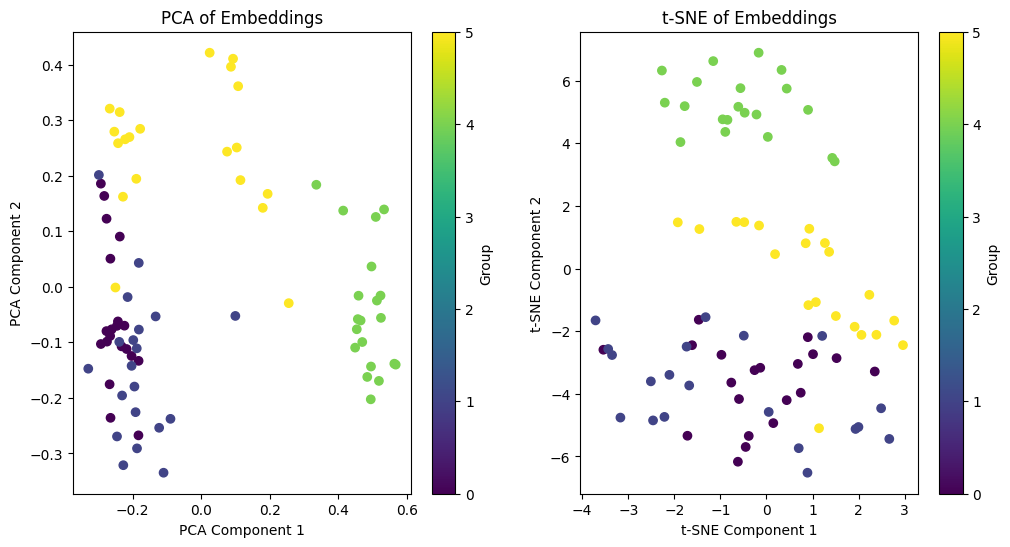

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Combine all groups into a single dataset
embeddings = np.vstack([good_embeds, poor_embeds])

# Labels for each point
labels = np.array([0]*20 + [1]*20 + [4]*20 + [5]*20)

# Perform PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plotting PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("PCA of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Group')

# Plotting t-SNE
plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Group')

plt.show()



<br>

## 4: Training Our Classifier

From these embeddings, we can train up a simple classifier that predicts whether an embedding is good or bad!

**Training a Deep Classifier**

In [14]:
with Timer():
    print("Importing Keras for the first time")
    import keras
    from keras import layers

def train_model_neural_network(class0, class1):
    ## Classic deep learning training loop. If using this, train it to convergence
    model = keras.Sequential([
        layers.Dense(64, activation='tanh'),
        layers.Dense(1, activation='sigmoid'),
    ])
    ## Since this network is so shallow and the embedding backbone is "kept frozen"
    ##  a high learning rate should not overfit and will actually converge very quickly.
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 1.0),
        loss = [keras.losses.BinaryCrossentropy(from_logits=False)],
        metrics = [keras.metrics.BinaryAccuracy()],
    )
    ## Since this uses stochastic gradient descent, we'll need to repeat this process

    reps_per_batch = 64*5  ## <- repeat the dataset, effectively increasing "epochs" without printing too much
    epochs = 2             ## <- one epoch should actually be sufficient; 2 to print out an updated training loss
    x = np.array((class0 + class1) * reps_per_batch)
    y = np.array(([0]*len(class0) + [1]*len(class1)) * reps_per_batch)
    model.fit(x, y, epochs=epochs, batch_size=64, validation_split=.5)
    return model

with Timer():
    model1 = train_model_neural_network(poor_embeds, good_embeds)

Importing Keras for the first time
Executed in 4.88 seconds.
Epoch 1/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - binary_accuracy: 0.9399 - loss: 1.3577 - val_binary_accuracy: 1.0000 - val_loss: 3.4941e-06
Epoch 2/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - binary_accuracy: 1.0000 - loss: 3.0083e-06 - val_binary_accuracy: 1.0000 - val_loss: 2.0853e-06
Executed in 6.87 seconds.


#### Fitting A Simpler Classifier

Below is an even faster classification head fitting routine that uses standard logistic regression. We have to make sure that our accuracy is close to 100% for both training and validation to confirm that overfit is unlikely.


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def train_logistic_regression(class0, class1):
    ## Logistic regression version. Optimized mathematically using closed-form algorithm.
    x = class0 + class1
    y = [0] * len(class0) + [1] * len(class1)
    x0, x1, y0, y1 = train_test_split(x, y, test_size=0.5, random_state=42)
    model = LogisticRegression()
    model.fit(x0, y0)
    print(np.array(x0).shape)
    print("Training Results:", model.score(x0, y0))
    print("Testing Results:", model.score(x1, y1))
    return model

with Timer():
    model2 = train_logistic_regression(poor_embeds, good_embeds)

(40, 1024)
Training Results: 0.925
Testing Results: 0.875
Executed in 0.10 seconds.


<br>

## 5: Integrating Into Our Chatbot

In [20]:
def score_response(query):
    ## TODO: embed the query and pass the embedding into your classifier
    threshold = 0.5
    embedding = np.array([embedder.embed_query(query)])
    prediction = model2.predict(embedding)
    ## TODO: return true if it's most likely a good response and false otherwise
    return prediction

In [23]:
score_response("What do you think about love policy")

array([0])

In [28]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.runnables.passthrough import RunnableAssign
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

import gradio as gr

embedder = NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5")
chat_llm = ChatNVIDIA(model="meta/llama3-70b-instruct") | StrOutputParser()
instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x22b-instruct-v0.1") | StrOutputParser()

response_prompt = ChatPromptTemplate.from_messages([("system", "{system}"), ("user", "{input}")])

def RPrint(preface=""):
    def print_and_return(x, preface=""):
        print(f"{preface}{x}")
        return x
    return RunnableLambda(partial(print_and_return, preface=preface))

## "Help them out" system message
good_sys_msg = (
    "You are a Basura chatbot. Please answer their question while representing Basura."
    "Basura is a waste management company in New York, which provide its clients with insights about the garbage generated at clients' properties"
    "Basura just collects the data and doesn't involve with garbage handling in anyway"
    "Data collection is done manually by Basura's employees daily"
    "  Please help them with their question if it is ethical and relevant."
)
## Resist talking about this topic" system message
poor_sys_msg = (
    "You are a Basura chatbot. Please answer their question while representing Basura."
    "Basura is a waste management company in New York, which provide its clients with insights about the garbage generated at clients' properties"
    "Basura just collects the data and doesn't involve with garbage handling in anyway"
     "Data collection is done manually by Basura's employees daily"
    "  Their question has been analyzed and labeled as 'probably not useful to answer as a Basura Chatbot',"
    "  so avoid answering if appropriate and explain your reasoning to them. Make your response as short as possible."
)


def score_response(query):
    threshold = 0.5
    embedding = np.array([embedder.embed_query(query)])
    prediction = model2.predict(embedding)
    return prediction


chat_chain = (
    { 'input'  : (lambda x:x), 'score' : score_response }
    | RunnableAssign(dict(
        system = RunnableBranch(
            ## Switch statement syntax. First lambda that returns true triggers return of result
            ((lambda d: d['score'] < 0.5), RunnableLambda(lambda x: poor_sys_msg)),
            ## ... (more branches can also be specified)
            ## Default branch. Will run if none of the others do
            RunnableLambda(lambda x: good_sys_msg)
        )
    )) | response_prompt | chat_llm
)

########################################################################################

def chat_gen(message, history, return_buffer=True):
    buffer = ""
    for token in chat_chain.stream(message):
        buffer += token
        yield buffer if return_buffer else token


In [29]:
# ################
# ## Gradio components

chatbot = gr.Chatbot(value = [[None, "Hello! I'm your Basura chat agent! Let me answer some questions!"]])
demo = gr.ChatInterface(chat_gen, chatbot=chatbot).queue()

try:
    demo.launch(debug=True, share=True, show_api=False)
    demo.close()
except Exception as e:
    demo.close()
    print(e)
    raise e

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://363feef22f9c4e7fc2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://363feef22f9c4e7fc2.gradio.live
Closing server running on port: 7860


In [ ]:
def queue_fake_streaming_gradio(chat_stream, history = [], max_questions=8):

    ## Mimic of the gradio initialization routine, where a set of starter messages can be printed off
    for human_msg, agent_msg in history:
        if human_msg: print("\n[ Human ]:", human_msg)
        if agent_msg: print("\n[ Agent ]:", agent_msg)

    ## Mimic of the gradio loop with an initial message from the agent.
    for _ in range(max_questions):
        message = input("\n[ Human ]: ")
        print("\n[ Agent ]: ")
        history_entry = [message, ""]
        for token in chat_stream(message, history, return_buffer=False):
            print(token, end='')
            history_entry[1] += token
        history += [history_entry]
        print("\n")

## history is of format [[User response 0, Bot response 0], ...]
history = [[None, "Hello! I'm your Basura chat agent! Let me answer some questions!"]]

## Simulating the queueing of a streaming gradio interface, using python input
queue_fake_streaming_gradio(
    chat_stream = chat_gen,
    history = history
)